In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Constants
FOLDER_PATH = '../data/rsva/samples/separated/'
SUB_FOLDER = '/a/output_files/'
SAMPLE_NAME = 'derep'
KMER_SIZE = 150
L_GENE_START = 8000
L_GENE_END = 16000
COVERAGE_RATIO = 0.5
REF_FILE = 'EPI_ISL_412866_RSVA_ref.fasta'
REF_ADDRESS = os.path.join('../data/rsva/reference/a', REF_FILE)

SAMPLE_ADDRESS = '../data/rsva/samples/aligned/derep.fasta.aln'
VARIANT = 'a'

In [2]:


def read_wig(wig_file_path):
    """
    Reads a WIG file and returns the values as a pandas Series with positions as index.
    """
    positions = []
    values = []
    
    print(f"Reading WIG file: {wig_file_path}")
    with open(wig_file_path, 'r') as wig_file:
        for line in wig_file:
            if line.startswith('variableStep'):
                continue
            parts = line.strip().split()
            if len(parts) == 2:
                position = int(parts[0])
                value = float(parts[1])
                positions.append(position)
                values.append(value)
    data_series = pd.Series(data=values, index=positions)
    print(f"Read {len(data_series)} values from {wig_file_path}")
    return data_series

def prepare_df(folder_path, sub_folder, KMER_SIZE):
    """
    Prepares a DataFrame by reading WIG files from the specified folder.
    """
    print(f"Preparing DataFrame from WIG files in {folder_path}")
    files = os.listdir(folder_path)
    print(f"Found {len(files)} files in {folder_path}")

    data_list = []
    for file in files:
        # path = os.path.join(folder_path, file, sub_folder, f"{file}_{KMER_SIZE}_conservative.wig")
        path = ''.join([folder_path, file, sub_folder, f"{file}_{KMER_SIZE}_conservative.wig"])
        # path = ''.join([folder_path,file, sub_folder, file, f'_{KMER_SIZE}_conservative.wig'])

        # print(folder_path)
        # print(file)
        # print(sub_folder)
        # break
        try:
            data_series = read_wig(path)
            data_series.name = file
            data_list.append(data_series)
            print(f"Added data for {file}")
        except FileNotFoundError:
            print(f"File not found: {path}, skipping.")
            continue

    df = pd.DataFrame(data_list)
    df = df.fillna(0)
    max_sum = df.sum().max()
    print(f"DataFrame prepared. Max sum of values per position: {max_sum}")

    return df

def plot_rel_cons(df, SAMPLE_NAME, KMER_SIZE):
    """
    Plots the histogram of kmer coverage by position.
    """
    print(f"Plotting kmer coverage for sample {SAMPLE_NAME} with kmer size {KMER_SIZE}")
    x = df.columns.values
    y = df.sum().values
    change_indices_y = np.where(y[:-1] != y[1:])[0]
    change_indices_y = np.concatenate(([0], change_indices_y, [len(y) - 1]))
    x_steps_y = x[change_indices_y]
    y_steps = y[change_indices_y]
    x_steps_y = np.append(x_steps_y, x_steps_y[-1] + 1)
    y_steps = np.append(y_steps, 0)
    
    plt.figure(figsize=(12, 6), dpi=300)
    plt.step(x_steps_y, y_steps, where='post', label='# dereplicated covered genomes', color='blue')
    plt.title(f'Histogram of the kmer coverage by position | kmer size = {KMER_SIZE} | 3 changes max')
    plt.xlabel('Kmer Start Position')
    plt.ylabel('Frequency')
    plt.legend()
    output_filename = f'Comparison_of_Conservative_frequencies_{SAMPLE_NAME}_{KMER_SIZE}.png'
    plt.savefig(output_filename, dpi=300)
    print(f"Plot saved as {output_filename}")
    plt.show()

def abundant_kmers(df):
    """
    Finds abundant kmers and the samples covering them.
    """
    print("Finding abundant kmers...")
    data = df.copy()
    output = dict()
    samples = dict()
    while True:
        pos = data.sum().idxmax()
        rep = data.sum().max()
        output[pos] = int(rep)
        print(f"Kmer start pos: {pos} has appeared in {int(rep)} samples / {data.shape[0]} samples")
        samples[pos] = data[data[pos]==1].index.values
        data = data[data[pos]!=1]
        total_remaining = data.sum().sum()
        if total_remaining <1:
            print("No more kmers left to process.")
            break
        else:
            print(f"Remaining kmers to process: {total_remaining}")
    return output, samples

def find_min_coverage_threshold(df, coverage_ratio=0.5):
    """
    Calculates the minimum coverage threshold based on the coverage ratio.
    """
    min_coverage = int(df.shape[0] * coverage_ratio)
    print(f"Minimum coverage threshold set to {min_coverage} based on coverage ratio {coverage_ratio}")
    return min_coverage

def limit_to_l_gene(df, start, end):
    """
    Limits the DataFrame to the specified gene region.
    """
    print(f"Limiting DataFrame to gene region from position {start} to {end}")
    ldf = df.loc[:, (df.columns >= start) & (df.columns <= end)]
    return ldf

def crop_df(df, start, end, coverage_ratio=0.5):
    """
    Crops the DataFrame to the specified gene region and coverage threshold.
    """
    ldf = limit_to_l_gene(df, start, end)
    min_coverage = find_min_coverage_threshold(ldf, coverage_ratio)
    ldf = ldf.loc[:, ldf.sum() > min_coverage]
    print(f"DataFrame cropped to {ldf.shape[1]} columns with coverage above threshold.")
    return ldf

def build_coverage_table(ldf):
    """
    Builds a coverage table for combinations of kmers.
    """
    print("Building coverage table for kmers...")
    data = ldf.values
    column_names = ldf.columns.tolist()
    num_kmers = len(column_names)
    coverage_list = []

    for i, j in itertools.combinations(range(num_kmers), 2):
        k1, k2 = column_names[i], column_names[j]
        union_sum = np.sum((data[:, i] + data[:, j]) > 0)
        k1_cov = data[:, i].sum()
        k2_cov = data[:, j].sum()
        total_cov = k1_cov + k2_cov
        coverage_list.append({
            'k1': k1,
            'k2': k2,
            'union_sum': union_sum,
            'k1_cov': k1_cov,
            'k2_cov': k2_cov,
            'k1_cov_plus_k2_cov': total_cov
        })
    coverage_df = pd.DataFrame(coverage_list)
    coverage_df = coverage_df.loc[(coverage_df[['k1_cov', 'k2_cov', 'union_sum']] != 0).any(axis=1)]
    coverage_df = coverage_df.sort_values(by=['union_sum', 'k1_cov_plus_k2_cov'], ascending=False)
    print(f"Coverage table built with {len(coverage_df)} combinations.")
    return coverage_df

def top_kmers_df(cov_df):
    """
    Returns the top kmers based on maximum union_sum and total coverage.
    """
    max_union_sum = cov_df['union_sum'].max()
    sub_df = cov_df[cov_df['union_sum'] == max_union_sum]
    max_total_cov = sub_df['k1_cov_plus_k2_cov'].max()
    sub_df = sub_df[sub_df['k1_cov_plus_k2_cov'] == max_total_cov]
    print(f"Top kmers found covering {max_union_sum} samples with total coverage {max_total_cov}")
    return sub_df

def read_fasta_to_dataframe(fasta_file):
    """
    Reads a FASTA file and returns a DataFrame with sequence IDs and sequences.
    """
    print(f"Reading FASTA file: {fasta_file}")
    sequences = []
    sequence_id = ''
    sequence = ''
    with open(fasta_file, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                if sequence:
                    sequences.append({'ID': sequence_id, 'Sequence': sequence})
                    sequence = ''
                sequence_id = line[1:]
            else:
                sequence += line
        if sequence:
            sequences.append({'ID': sequence_id, 'Sequence': sequence})

    df = pd.DataFrame(sequences)
    print(f"Read {len(df)} sequences from {fasta_file}")
    return df


In [3]:
import pandas as pd

def read_fasta_to_dataframe(fasta_file):
    """Reads a FASTA file and returns a DataFrame with sequence IDs and sequences."""
    with open(fasta_file, 'r') as file:
        sequences = []
        sequence_id = ''
        sequence = ''
        for line in file:
            line = line.strip()
            if line.startswith('>'):  # Header line
                if sequence:  # Save previous sequence before starting a new one
                    sequences.append([sequence_id, sequence])
                    sequence = ''  # Reset sequence
                sequence_id = line[1:]  # Remove '>' and take the rest as ID
            else:
                sequence += line
        if sequence:  # Ensure the last sequence is also added
            sequences.append([sequence_id, sequence])
    
    # Creating a DataFrame
    df = pd.DataFrame(sequences, columns=['ID', 'Sequence'])
    return df


import pandas as pd
from collections import defaultdict, Counter
import re

def extract_year(id_string):
    """
    Extracts the year from the sequence ID.
    Assumes that the year is a 4-digit number following a pipe '|' in the ID.
    """
    match = re.search(r'\|(\d{4})\b', id_string)  # Look for a 4-digit year
    if match:
        return int(match.group(1))  # Convert year to an integer
    return 'No Year'

# Function to decide if the group should be kept or removed
def filter_group_by_year(group, min_year=2020, threshold=100):
    # If the group is smaller than 1% of total rows
    if len(group) < threshold:
        years = group['year']
        # Check if years end in min_year or cross min_year
        if years.max() == min_year:
            if years.min() <min_year:
                return False
        if years.max() < min_year:
            return False         
    return True

# Drop kmers which have more than 3 changes to the most frequent kmer
def filter_kmers_by_changes(df_samples, kmer_name='kmer1', num_changes_threshold=3):
    """
    Filters the DataFrame to return rows where the subsequence has more than a specified number of changes compared to the
    most frequent subsequence and adds a new column showing the number of changes.
    
    Parameters:
    - df_samples: pandas DataFrame with columns ['ID', 'kmer1'].
    - kmer_name: Name of the kmer column (default is 'kmer1').
    - num_changes_threshold: The minimum number of changes to filter by (default is 3).
    
    Returns:
    - DataFrame with rows having more than `num_changes_threshold` changes and a new column 'num_changes' showing the count.
    """
    # Drop rows where 'Subsequence' (kmer1) is NaN
    df_samples_clean = df_samples[['ID', kmer_name]].dropna()

    # Count frequency of each subsequence
    subseq_freq = Counter(df_samples_clean[kmer_name])

    # Sort subsequences by frequency in descending order
    sorted_subsequences = sorted(subseq_freq.items(), key=lambda x: x[1], reverse=True)
    
    # Get the most frequent subsequence
    most_frequent_subseq = sorted_subsequences[0][0]

    # Create a list to hold subsequences with more than the threshold number of changes
    subseq_with_changes = []

    # Iterate through the subsequences and calculate the number of changes
    for idx, row in df_samples_clean.iterrows():
        subseq = row[kmer_name]
        comparison = compare_kmers(subseq, most_frequent_subseq)
        num_changes = len([char for char in comparison if char != '-'])  # Count only the changed characters
        
        # If the number of changes is greater than the threshold, add it to the list
        if num_changes > num_changes_threshold:
            subseq_with_changes.append({
                'ID': row['ID'],
                kmer_name: subseq,
                'num_changes': num_changes
            })

    # Convert the list of results into a DataFrame
    df_with_changes = pd.DataFrame(subseq_with_changes)

    return df_with_changes



import pandas as pd
from collections import defaultdict, Counter
import re

def extract_year(id_string):
    """
    Extracts the year from the sequence ID.
    Assumes that the year is a 4-digit number following a pipe '|' in the ID.
    """
    match = re.search(r'\|(\d{4})\b', id_string)
    if match:
        return int(match.group(1))
    return None

def get_subsequences_with_years(df_samples, kmer_column):
    """
    Extracts subsequences and their associated years from the given DataFrame.

    Parameters:
    - df_samples: pandas DataFrame with columns ['ID', kmer_column].
    - kmer_column: Name of the column containing kmers.

    Returns:
    - subseq_to_years: Dictionary mapping subsequences to associated years.
    - subseq_freq: Counter object for the frequency of subsequences.
    """
    df_clean = df_samples[['ID', kmer_column]].dropna()

    subseq_to_years = defaultdict(list)
    for idx, row in df_clean.iterrows():
        year = extract_year(row['ID'])
        if year:
            subseq_to_years[row[kmer_column]].append(year)
    
    subseq_freq = Counter(df_clean[kmer_column])
    return subseq_to_years, subseq_freq

def get_sorted_subsequences(subseq_freq):
    """
    Sorts subsequences by frequency in descending order.

    Parameters:
    - subseq_freq: Counter object with subsequence frequencies.

    Returns:
    - sorted_subsequences: List of sorted subsequences with their frequencies.
    """
    return sorted(subseq_freq.items(), key=lambda x: x[1], reverse=True)

def compare_sequences(reference, sequence):
    """
    Compares a subsequence to the reference sequence and returns an alignment string.
    Matching positions are replaced with '-', and non-matching positions retain the sequence's character.

    Parameters:
    - reference: The reference subsequence (most frequent).
    - sequence: The sequence to compare.

    Returns:
    - comparison: A string showing the comparison result.
    """
    # If the sequence is the same as the reference, return the sequence itself (no dashes)
    if reference == sequence:
        return reference

    return ''.join('-' if ref_char == seq_char else seq_char for ref_char, seq_char in zip(reference, sequence))

def count_changes(reference, sequence):
    """
    Counts the number of changes between the reference sequence and the given sequence,
    ignoring dashes ('-') in either sequence.

    Parameters:
    - reference: The reference subsequence (most frequent).
    - sequence: The sequence to compare.

    Returns:
    - changes: The number of differences between the sequences where both have valid characters (ignoring dashes).
    """
    changes = 0
    for ref_char, seq_char in zip(reference, sequence):
        if ref_char != '-' and seq_char != '-' and ref_char != seq_char:
            changes += 1
    return changes

def simulate_year_bars(years, total_width=60, start_year=1965, end_year=2025):
    """
    Creates a string of dashes representing the year range based on a list of years.

    Parameters:
    - years: List of years.
    - total_width: Number of characters to represent the year range (default: 40).
    - start_year: Start of the year range (default: 1985).
    - end_year: End of the year range (default: 2025).

    Returns:
    - bar: A string representing the year span using dashes.
    """
    if not years:
        return ' ' * total_width

    min_year, max_year = min(years), max(years)
    start_pos = int(((min_year - start_year) / (end_year - start_year)) * total_width)
    end_pos = int(((max_year - start_year) / (end_year - start_year)) * total_width)

    bar = [' ' for _ in range(total_width)]
    for i in range(start_pos, end_pos + 1):
        bar[i] = '-'
    
    return ''.join(bar)

def create_kmers_dataframe(sorted_subsequences, subseq_to_years, most_frequent_subseq, total_subsequences):
    """
    Creates a DataFrame with Seq_ID, year range, percentage, alignment, and changes.

    Parameters:
    - sorted_subsequences: List of sorted subsequences with their frequencies.
    - subseq_to_years: Dictionary mapping subsequences to years.
    - most_frequent_subseq: The most frequent subsequence (reference).
    - total_subsequences: Total number of subsequences (for percentage calculation).

    Returns:
    - df_kmers: A Pandas DataFrame containing the processed subsequences and associated data.
    """
    data = []
    for i, (subseq, freq) in enumerate(sorted_subsequences, start=1):
        percentage = (freq / total_subsequences) * 100
        years = subseq_to_years[subseq]
        s_year = min(years) if years else None
        e_year = max(years) if years else None
        year_range = simulate_year_bars(years)

        # Handle reference sequence alignment and changes
        if subseq == most_frequent_subseq:
            alignment = subseq  # The reference sequence is shown as is (no dashes)
            changes = 0  # No changes for the reference sequence
        else:
            alignment = compare_sequences(most_frequent_subseq, subseq)
            changes = count_changes(most_frequent_subseq, subseq)

        data.append({
            "Seq_ID": i,
            "s_year": s_year,
            "e_year": e_year,
            "year_range": year_range,
            "percentage": f"{percentage:.2f}%",
            "alignment": alignment,
            "changes": changes
        })

    return pd.DataFrame(data)

def process_kmers_to_dataframe(df_samples, kmer_column):
    """
    Processes kmers and creates a DataFrame with relevant information about each subsequence.

    Parameters:
    - df_samples: Pandas DataFrame containing the sequence data.
    - kmer_column: Name of the column containing kmers.

    Returns:
    - df_kmers: A Pandas DataFrame with Seq_ID, year range, percentage, alignment, and changes.
    """
    subseq_to_years, subseq_freq = get_subsequences_with_years(df_samples, kmer_column)
    sorted_subsequences = get_sorted_subsequences(subseq_freq)
    most_frequent_subseq = sorted_subsequences[0][0]
    total_subsequences = sum(subseq_freq.values())

    return create_kmers_dataframe(sorted_subsequences, subseq_to_years, most_frequent_subseq, total_subsequences)


def compare_kmers(kmer, reference):
    """
    Compares a kmer with a reference sequence and returns a comparison string.
    Matching positions are replaced with '-', and non-matching positions retain the kmer's character.
    """
    result = []
    for i in range(len(kmer)):
        if kmer[i] == reference[i]:
            result.append('-')
        else:
            result.append(kmer[i])
    return ''.join(result)


def pipeline_results_cleaner(sample_address='../data/rsva/samples/aligned/derep.fasta.aln',
                             kmer1=11000, kmer2=12000, drop_old_samples=True,
                             kmer_size= 150, min_year=2020, threshold_ratio=0.01):
    
    df_samples = read_fasta_to_dataframe(sample_address)

    df_samples['kmer1'] = df_samples['Sequence'].str.slice(kmer1, kmer1+kmer_size)
    df_samples['kmer2'] = df_samples['Sequence'].str.slice(kmer2, kmer2+kmer_size)

    df_samples['year'] = df_samples['ID'].apply(extract_year)

    # Convert the 'year' column to numeric, coercing errors to NaN
    df_samples['year'] = pd.to_numeric(df_samples['year'], errors='coerce')

    # Drop rows where 'year' is NaN (i.e., non-numerical entries were converted to NaN)
    df_samples = df_samples.dropna(subset=['year'])

    ## Drop the samples containing Non ATCG chars in their kmer1 or kmer2
    df_samples = df_samples[~df_samples['kmer1'].str.contains('[^ATCG]', regex=True) & 
                            ~df_samples['kmer2'].str.contains('[^ATCG]', regex=True)]
    
    # drop old samples 
    if drop_old_samples:
        # Calculate the threshold for 1% of the total number of rows
        threshold = len(df_samples) * threshold_ratio

        # Group by 'kmer1'
        gk1 = df_samples.groupby('kmer1')
        gk2 = df_samples.groupby('kmer2')

        # Apply the filter and create a new DataFrame with only the groups to be kept
        filtered_df1 = gk1.filter(filter_group_by_year, min_year=min_year, threshold=threshold)
        filtered_df2 = gk2.filter(filter_group_by_year, min_year=min_year, threshold=threshold)

        filtered_ids1 = filtered_df1['ID']
        filtered_ids2 = filtered_df2['ID']

        ids = list(set(filtered_ids1.values).intersection(filtered_ids2.values))
        df_samples = df_samples[df_samples['ID'].isin(ids)]

    # Drop kmers which have more than 3 changes to the most frequent kmer
    df_changes1 = filter_kmers_by_changes(df_samples, kmer_name='kmer1', num_changes_threshold=3)
    df_changes2 = filter_kmers_by_changes(df_samples, kmer_name='kmer2', num_changes_threshold=3)

    ids_to_drop = list(set(df_changes1.ID.tolist()).union(df_changes2.ID.tolist()))
    df_samples = df_samples.loc[~df_samples['ID'].isin(ids_to_drop)]

    df_kmers1 = process_kmers_to_dataframe(df_samples, 'kmer1')
    df_kmers2 = process_kmers_to_dataframe(df_samples, 'kmer2')

    return df_kmers1, df_kmers2



Preparing DataFrame from WIG files in ../data/rsva/samples/separated/
Found 4081 files in ../data/rsva/samples/separated/
Reading WIG file: ../data/rsva/samples/separated/hRSV_A_Germany_RP-19-02346_2019/a/output_files/hRSV_A_Germany_RP-19-02346_2019_150_conservative.wig
Read 30152 values from ../data/rsva/samples/separated/hRSV_A_Germany_RP-19-02346_2019/a/output_files/hRSV_A_Germany_RP-19-02346_2019_150_conservative.wig
Added data for hRSV_A_Germany_RP-19-02346_2019
Reading WIG file: ../data/rsva/samples/separated/hRSV_A_Australia_VIC-RCH011_2021/a/output_files/hRSV_A_Australia_VIC-RCH011_2021_150_conservative.wig
Read 30152 values from ../data/rsva/samples/separated/hRSV_A_Australia_VIC-RCH011_2021/a/output_files/hRSV_A_Australia_VIC-RCH011_2021_150_conservative.wig
Added data for hRSV_A_Australia_VIC-RCH011_2021
Reading WIG file: ../data/rsva/samples/separated/hRSV_A_Kenya_KILIFI-WGS-1307-26-02_2015/a/output_files/hRSV_A_Kenya_KILIFI-WGS-1307-26-02_2015_150_conservative.wig
Read 301

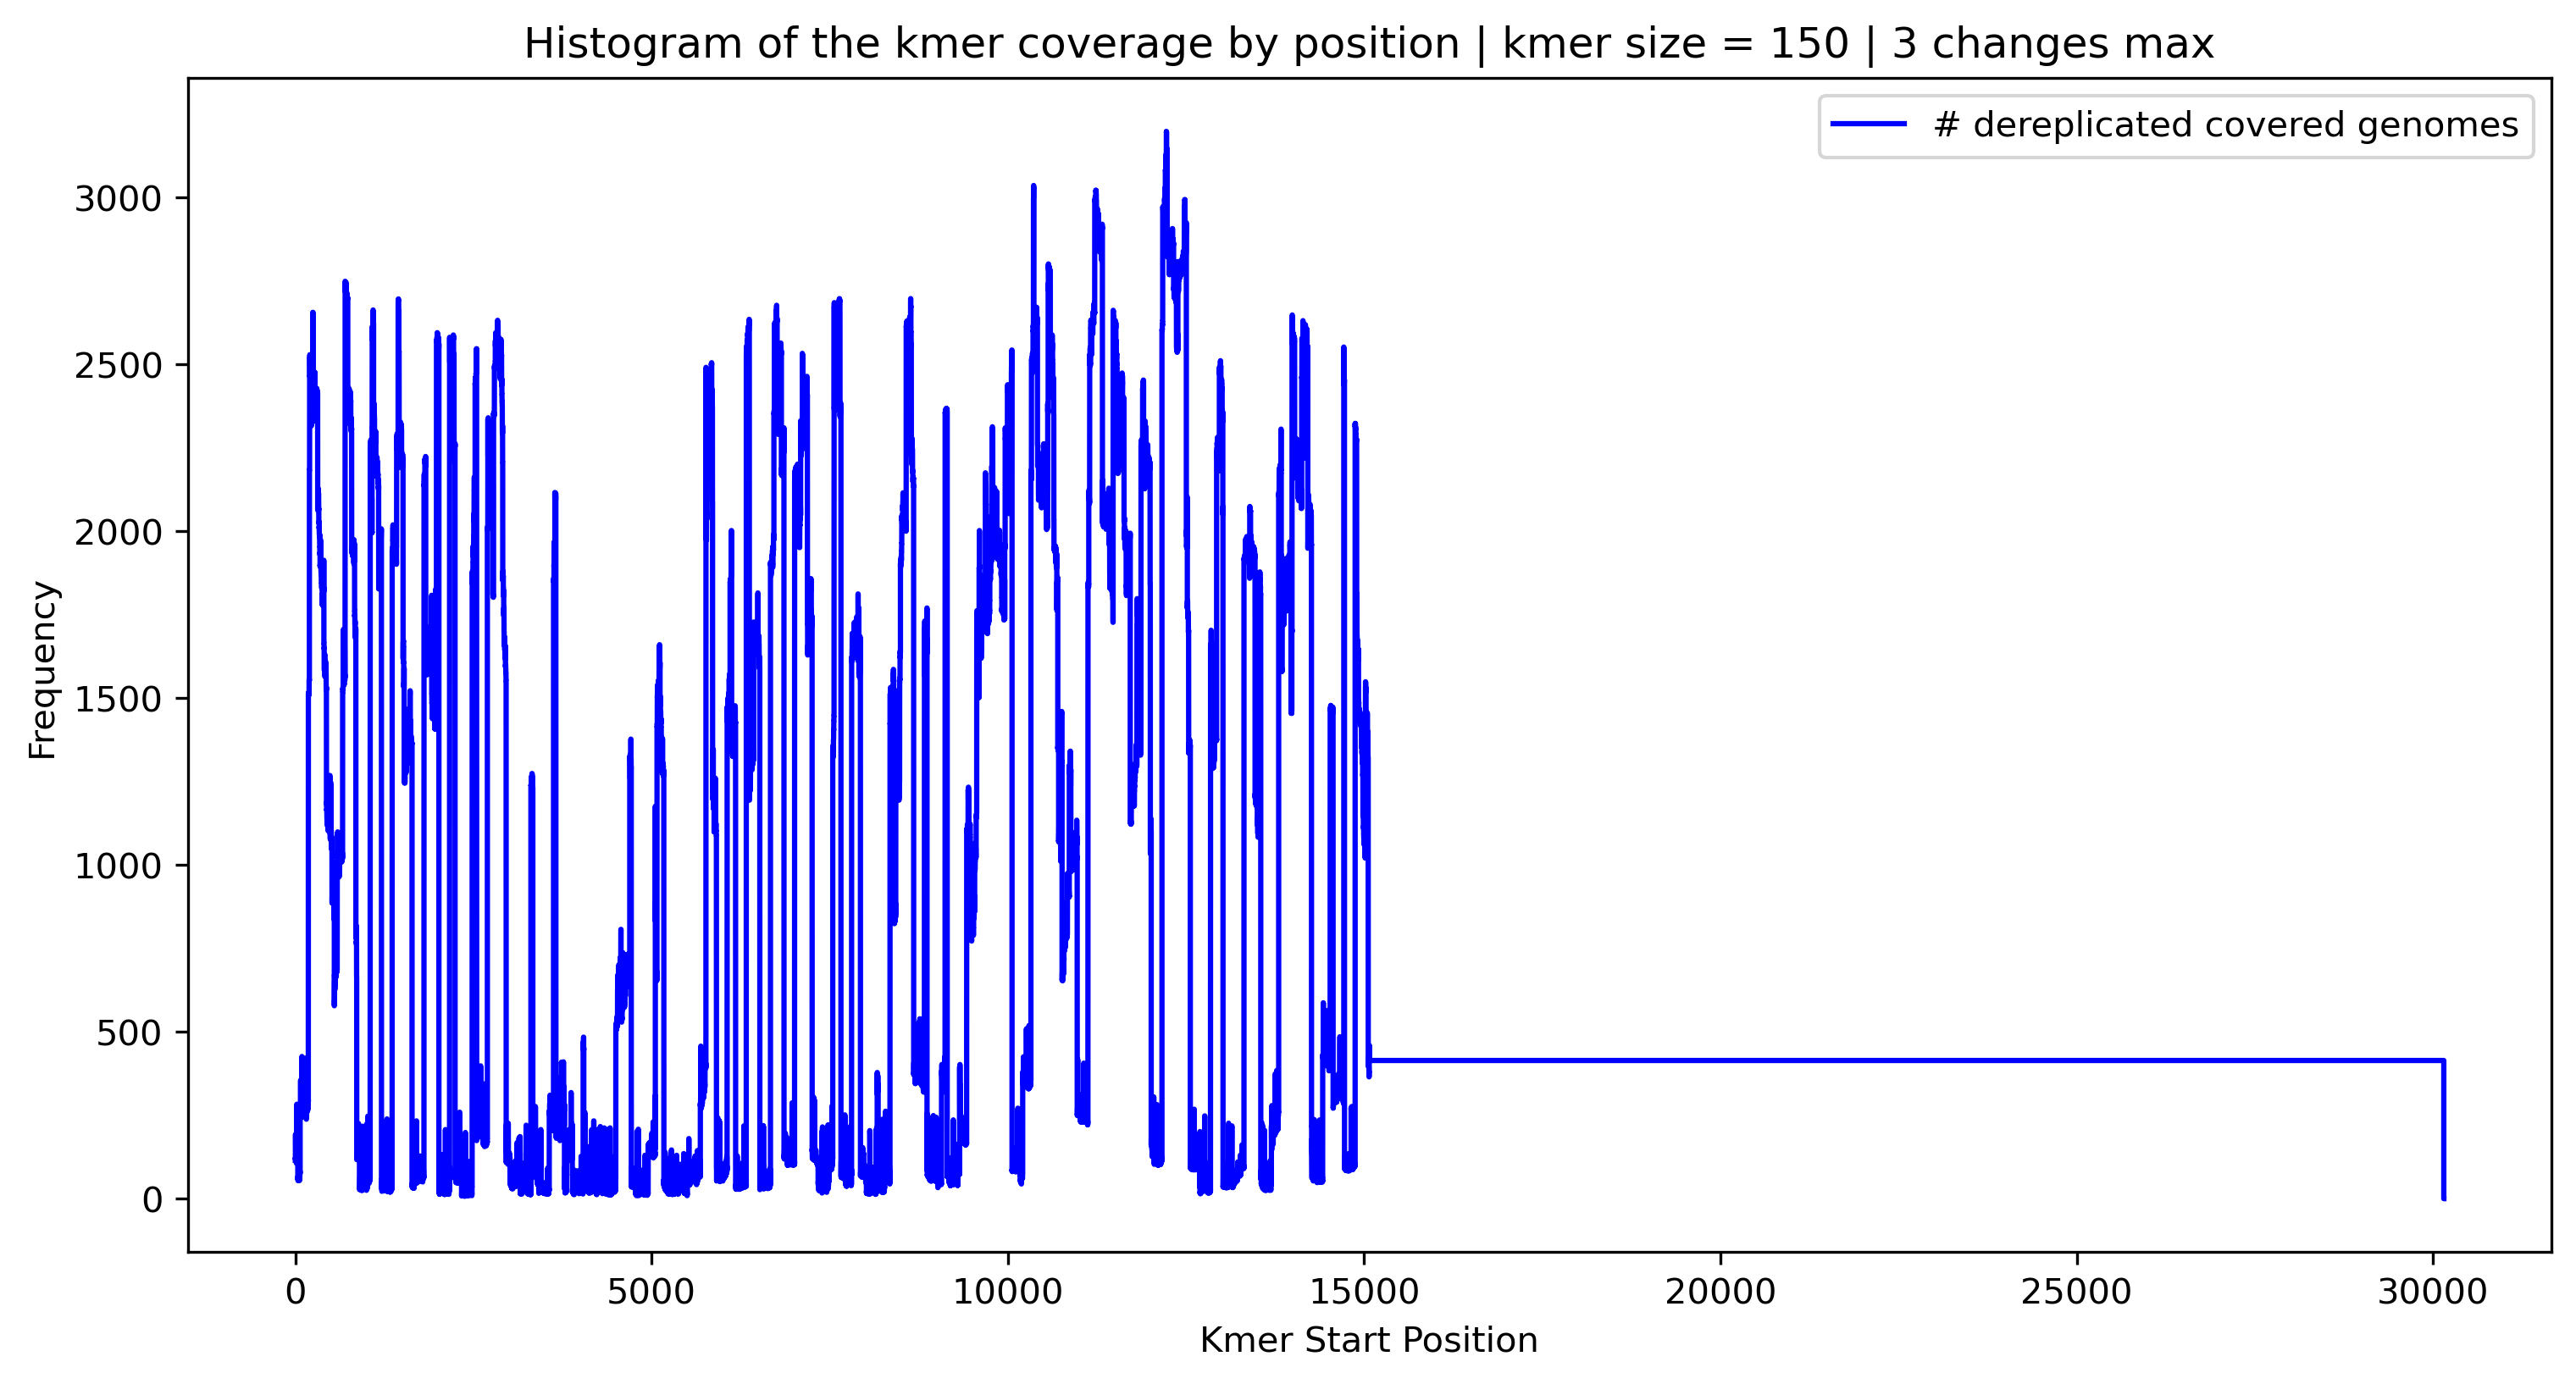

Finding abundant kmers...
Kmer start pos: 12225 has appeared in 3198 samples / 4081 samples
Remaining kmers to process: 1905546.0
Kmer start pos: 11901 has appeared in 529 samples / 883 samples
Remaining kmers to process: 915365.0
Kmer start pos: 10498 has appeared in 217 samples / 354 samples
Remaining kmers to process: 187538.0
Kmer start pos: 11441 has appeared in 70 samples / 137 samples
Remaining kmers to process: 65861.0
Kmer start pos: 8621 has appeared in 34 samples / 67 samples
Remaining kmers to process: 14908.0
Kmer start pos: 1481 has appeared in 9 samples / 33 samples
Remaining kmers to process: 4965.0
Kmer start pos: 14211 has appeared in 8 samples / 24 samples
Remaining kmers to process: 1632.0
Kmer start pos: 1419 has appeared in 3 samples / 16 samples
Remaining kmers to process: 11.0
Kmer start pos: 11910 has appeared in 1 samples / 13 samples
No more kmers left to process.
Limiting DataFrame to gene region from position 8000 to 16000
Minimum coverage threshold set to 

In [4]:

# Main execution
if __name__ == "__main__":
    # Prepare DataFrame from WIG files
    df = prepare_df(FOLDER_PATH, SUB_FOLDER, KMER_SIZE)
    
    # Plot kmer coverage
    plot_rel_cons(df, SAMPLE_NAME, KMER_SIZE)
    
    # Find abundant kmers
    sorted_kmers, samples = abundant_kmers(df)
    
    # Crop DataFrame to L gene region and apply coverage threshold
    ldf = crop_df(df, L_GENE_START, L_GENE_END, coverage_ratio=COVERAGE_RATIO)
    
    # Build coverage table
    cov_df = build_coverage_table(ldf)
    
    # Find top kmers
    sub_df = top_kmers_df(cov_df)
    
    set1 = np.unique(sub_df['k1'].values)
    print(f"Set1 kmers: {set1}")

    set2 = np.unique(sub_df['k2'].values)
    print(f"Set2 kmers: {set2}")

    kmer1, kmer2 = int(set1[0]), int(set2[0])
    print(f"Selected kmers: {kmer1}, {kmer2}")
    
    # Find remaining samples not covered by top kmers
    print("Finding remaining samples not covered by top kmers...")
    remaining_samples = df.loc[(df[kmer1] + df[kmer2]) == 0]
    remaining_samples_ids = list(remaining_samples.index)
    print(f"Number of remaining samples: {len(remaining_samples_ids)}")
    
    # Read reference sequence
    df_ref_b = read_fasta_to_dataframe(REF_ADDRESS)
    ref_seq = df_ref_b['Sequence'].values[0]
    
    # Extract kmer sequences
    kmer1_seq = ref_seq[kmer1:kmer1+KMER_SIZE]
    kmer2_seq = ref_seq[kmer2:kmer2+KMER_SIZE]
    
    print(f"Kmer1 sequence (position {kmer1}):\n{kmer1_seq}")
    print(f"Kmer2 sequence (position {kmer2}):\n{kmer2_seq}")



In [5]:
# Read reference sequence
df_ref_b = read_fasta_to_dataframe(REF_ADDRESS)
ref_seq = df_ref_b['Sequence'].values[0]

# Extract kmer sequences
kmer1_seq = ref_seq[kmer1:kmer1+KMER_SIZE]
kmer2_seq = ref_seq[kmer2:kmer2+KMER_SIZE]

print(f"Kmer1 sequence (position {kmer1}):\n{kmer1_seq}")
print(f"Kmer2 sequence (position {kmer2}):\n{kmer2_seq}")



Kmer1 sequence (position 11901):
TTGTTTATGAAAGTTTACCCTTTTATAAAGCAGAGAAAATAGTAAATCTTATATCCGGTACAAAATCTATAACTAACATACTGGAAAAGACTTCTGCCATAGACTTAACAGATATTGATAGAGCCACTGAGATGATGAGGAAAAACATAA
Kmer2 sequence (position 12225):
ATACAACAAGCACTATAGCTAGTGGCATAATCATAGAGAAATATAATGTCAACAGTTTAACACGTGGTGAGAGAGGACCCACTAAACCATGGGTTGGTTCATCTACACAAGAGAAAAAGACAATGCCAGTTTATAATAGACAAGTTTTAA


In [6]:
# Run the pipeline
df_kmers1_drop_old, df_kmers2_drop_old = pipeline_results_cleaner(sample_address=SAMPLE_ADDRESS,
                                                                 kmer1=kmer1, kmer2=kmer2, drop_old_samples=True,
                                                                 kmer_size= 150, min_year=2020, threshold_ratio=0.01)
df_kmers1_drop_old.to_excel(f"../results/{VARIANT}_kmer1_drop_old.xlsx")
df_kmers2_drop_old.to_excel(f"../results/{VARIANT}_kmer2_drop_old.xlsx")

df_kmers1, df_kmers2 = pipeline_results_cleaner(sample_address=SAMPLE_ADDRESS,
                             kmer1=kmer1, kmer2=kmer2, drop_old_samples=False,
                             kmer_size= 150, min_year=2020, threshold_ratio=0.01)
# df_kmers1.to_excel(f"../results/{VARIANT}_kmer1.xlsx")
# df_kmers2.to_excel(f"../results/{VARIANT}_kmer2.xlsx")

df_kmers1.to_csv(f"../results/{VARIANT}_kmer1.csv")
df_kmers2.to_csv(f"../results/{VARIANT}_kmer2.csv")

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def count_non_gap_characters_from_dataframe(df, sequence_column='alignment'):
    """
    Counts the number of non-gap ('-') characters at each position across all sequences in a DataFrame column.

    Parameters:
    df (pd.DataFrame): The DataFrame containing sequences.
    sequence_column (str): The name of the column containing sequences.

    Returns:
    pd.DataFrame: A DataFrame with positions as the index and counts as the values.
    """
    if sequence_column not in df.columns:
        raise ValueError(f"Column '{sequence_column}' does not exist in the DataFrame.")
    
    sequences = df[sequence_column].tolist()
    
    if not sequences:
        raise ValueError("The list of sequences is empty.")
    
    sequence_length = len(sequences[0])
    
    # Ensure all sequences are of the same length
    for seq in sequences:
        if len(seq) != sequence_length:
            raise ValueError("All sequences must be of the same length.")
    
    # Convert sequences to a 2D NumPy array
    seq_array = np.array([list(seq) for seq in sequences])
    
    # Create a boolean array where True indicates a non-gap character
    non_gap_array = seq_array != '-'
    
    # Sum over the sequences to get counts at each position
    counts = non_gap_array.sum(axis=0)
    
    # Create a DataFrame from the counts
    df_counts = pd.DataFrame({
        'Position': range(1, sequence_length + 1),
        'NonGapCount': counts
    })
    
    df_counts.set_index('Position', inplace=True)
    return df_counts

def plot_non_gap_counts(df_counts, title='Non-Gap Character Counts at Each Position'):
    """
    Plots the counts of non-gap characters at each position and saves the plot based on the title.

    Parameters:
    df_counts (pd.DataFrame): DataFrame containing counts of non-gap characters at each position.
    title (str): Title of the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.bar(df_counts.index, df_counts['NonGapCount'], color='blue')
    plt.xlabel('Position')
    plt.ylabel('Number of Non-Gap Characters')
    plt.title(title)
    plt.tight_layout()
    
    # Generate a filename based on the title
    filename = title.replace(' ', '_') + '.png'
    
    # Save the plot to a file
    plt.savefig(filename)
    print(f"Plot saved as {filename}")
    
    # Close the plot to free up memory
    plt.close()


In [14]:
df_counts = count_non_gap_characters_from_dataframe(df_kmers1_drop_old, sequence_column='alignment')
plot_non_gap_counts(df_counts, title=f'{VARIANT}**kmers1_drop_old -- Non-Gap Character Counts at Each Position')

df_counts = count_non_gap_characters_from_dataframe(df_kmers2_drop_old, sequence_column='alignment')
plot_non_gap_counts(df_counts, title=f'{VARIANT}**kmers2_drop_old -- Non-Gap Character Counts at Each Position')

df_counts = count_non_gap_characters_from_dataframe(df_kmers1, sequence_column='alignment')
plot_non_gap_counts(df_counts, title=f'{VARIANT}**kmers1 -- Non-Gap Character Counts at Each Position')

df_counts = count_non_gap_characters_from_dataframe(df_kmers2, sequence_column='alignment')
plot_non_gap_counts(df_counts, title=f'{VARIANT}**kmers2 -- Non-Gap Character Counts at Each Position')

Plot saved as a**kmers1_drop_old_--_Non-Gap_Character_Counts_at_Each_Position.png
Plot saved as a**kmers2_drop_old_--_Non-Gap_Character_Counts_at_Each_Position.png
Plot saved as a**kmers1_--_Non-Gap_Character_Counts_at_Each_Position.png
Plot saved as a**kmers2_--_Non-Gap_Character_Counts_at_Each_Position.png
